In [15]:
import math
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import breathDetectionFunctions as bd   
% matplotlib inline

#breathDetection_v1.2

#This breath detection model tries to detect the filling and emptying of the users lungs based on whether the chest sensor is extended more than or less than moving average at a given time.
 

#New this version: 
#- went back to calculating 30s average breath rate

#- Basic rejection algorithm discards breath times shorter than 1.5s and longer than 16s from the calculation of the breath rate. This filter is implemented throug hthe "filterBreaths" function.

#- plotting average of rise and fall breath rate as well (rfmav)

In [16]:
# read in dataset Jill
dset = pd.read_csv('SapnaData_I.txt',sep = ' ') # read in dataset
#dset.columns = ['chest','belly','ax','ay','az','gx','gy','gz']
#dset['time'] = dset.index*(1/20) # add timestamp assuming 20 samples / second
#print(dset.head(5))
print(dset.shape[0])
print(dset.shape[0]/600)

7318
12.196666666666667


In [17]:
# pick subsample (just for visualization purposes, so I am not plotting the whole dataset each time.)
d = pd.DataFrame(data = dset[0:dset.shape[0]]) # select which data points; used to be [:8000]
#d = pd.DataFrame(data = dset[0:25000]) # select which data points; used to be [:8000]
d.index = pd.RangeIndex(start = 0, stop = len(d), step = 1) # to measure time from beginning of sub-sample
d.columns = ['chest','belly','ax','ay','az','gx','gy','gz']
d['time'] = d.index*(1/10) # add timestamp assuming 10 samples / second
#print(d.head(5))

d = d.reset_index()

# smoothen sample: subsecond dynamics are removed using exponentially weighted moving average
d['cesm'] = d['chest'].rolling(window = 100,center = False).apply(lambda x: bd.expSmoothen(x,20)) # smoothen
d['besm'] = d['belly'].rolling(window = 100,center = False).apply(lambda x: bd.expSmoothen(x,20)) # smoothen

# calculate [6] second moving average and subtract it from smoothened signal to remove long-term drift 
d['cmav'] = d['chest'].rolling(window = 7*20,center = False).mean() - 0 # slight offset because breaths are held for some time.
d['del'] = d['cesm'] - d['cmav']

d['bmav'] = d['belly'].rolling(window = 7*20,center = False).mean() - 0 # slight offset because breaths are held for some time.
d['bdel'] = d['besm'] - d['bmav']

# identify breath phase: distinguishes between above-average and below-average expansion of the sensor. 
d['ph1'] = d['del'].apply(bd.phase) # function: +1 if positive, -1 if negative
d['ph2'] = d['bdel'].apply(bd.phase) # function: +1 if positive, -1 if negative

# take derivative of phase curve: +1 where rise, -1 where fall
d['ph1_slp'] = 0.025*d['ph1'].rolling(window = 2, center = False).apply(bd.slp)
d['ph2_slp'] = 0.025*d['ph2'].rolling(window = 2, center = False).apply(bd.slp)

# store vector with the last [-x:] rise times,
d['riseTimes'] = d['time'].apply(lambda x: d['time'][0:int(x/(1/20))][d['ph1_slp'][0:int(x/(1/20))]>0].values[-10:])
d['briseTimes'] = d['time'].apply(lambda x: d['time'][0:int(x/(1/20))][d['ph2_slp'][0:int(x/(1/20))]>0].values[-10:])

# store vector with the last [-x:] fall times
d['fallTimes'] = d['time'].apply(lambda x: d['time'][0:int(x/(1/20))][d['ph1_slp'][0:int(x/(1/20))]<0].values[-10:])
d['bfallTimes'] = d['time'].apply(lambda x: d['time'][0:int(x/(1/20))][d['ph2_slp'][0:int(x/(1/20))]<0].values[-10:])

# calculate last [19] breath times based on rise times
d['rbtime'] = d['riseTimes'].apply(lambda x: x[1:] - x[:-1])
# calculate last [19] breath times based on fall times
d['fbtime'] = d['fallTimes'].apply(lambda x: x[1:] - x[:-1])
# calculate last [19] breath times based on rise times
d['brbtime'] = d['briseTimes'].apply(lambda x: x[1:] - x[:-1])
# calculate last [19] breath times based on fall times
d['bfbtime'] = d['bfallTimes'].apply(lambda x: x[1:] - x[:-1])

# replace empty entries with NaN
def repNan(x):
    if len(x) == 0:
        return [np.nan]
    else:
        return x
    
# filter all breath measurements that are unrealistically short or long
def filterBreaths(x):
    return [d for d in x if d > 1.5 and d < 24]
    
d['rbtime'] = d['rbtime'].apply(lambda x: filterBreaths(x)).apply(repNan)
d['fbtime'] = d['fbtime'].apply(lambda x: filterBreaths(x)).apply(repNan)
d['brbtime'] = d['brbtime'].apply(lambda x: filterBreaths(x)).apply(repNan)
d['bfbtime'] = d['bfbtime'].apply(lambda x: filterBreaths(x)).apply(repNan)

#def lastEntry(x):
#    if len(x) > 0:
#        return x[-1]
#    else:
#        return np.nan
    
d['rlast'] = d['rbtime'].apply(lambda x: x[-1])
d['flast'] = d['fbtime'].apply(lambda x: x[-1])
d['brlast'] = d['brbtime'].apply(lambda x: x[-1])
d['bflast'] = d['bfbtime'].apply(lambda x: x[-1])

# calculate averaged breath time 
d['rmav'] = d['rlast'].rolling(window = 30*20, center = False).mean().apply(lambda x: 60/x)
d['fmav'] = d['flast'].rolling(window = 30*20, center = False).mean().apply(lambda x: 60/x) # calculate 30s average breath rate
d['rfmav'] = (d['rmav']+ d['fmav'])/2

d['brmav'] = d['brlast'].rolling(window = 30*20, center = False).mean().apply(lambda x: 60/x)
d['bfmav'] = d['bflast'].rolling(window = 30*20, center = False).mean().apply(lambda x: 60/x) # calculate 30s average breath rate
d['brfmav'] = (d['brmav']+ d['bfmav'])/2

#Breathing rate averages Chest and Belly
d['cbrfmav'] = d['brfmav']*0.1+d['rfmav']*0.9

# movement data acceleration
d['acc'] = d['ax'].multiply(d['ax']) + d['ay'].multiply(d['ay']) + d['az'].multiply(d['az'])

# movement data angular velocity
d['gyr'] = d['gx'].multiply(d['gx']) + d['gy'].multiply(d['gy']) + d['gz'].multiply(d['gz'])

In [18]:
f = d

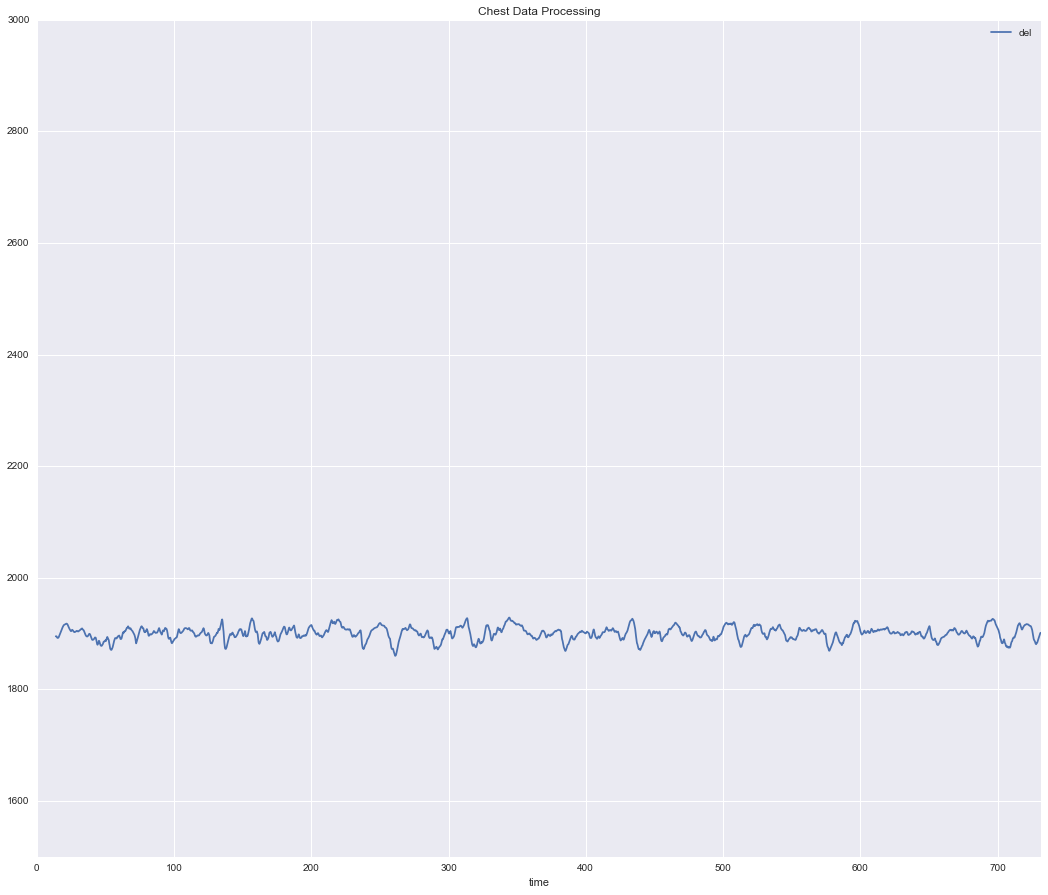

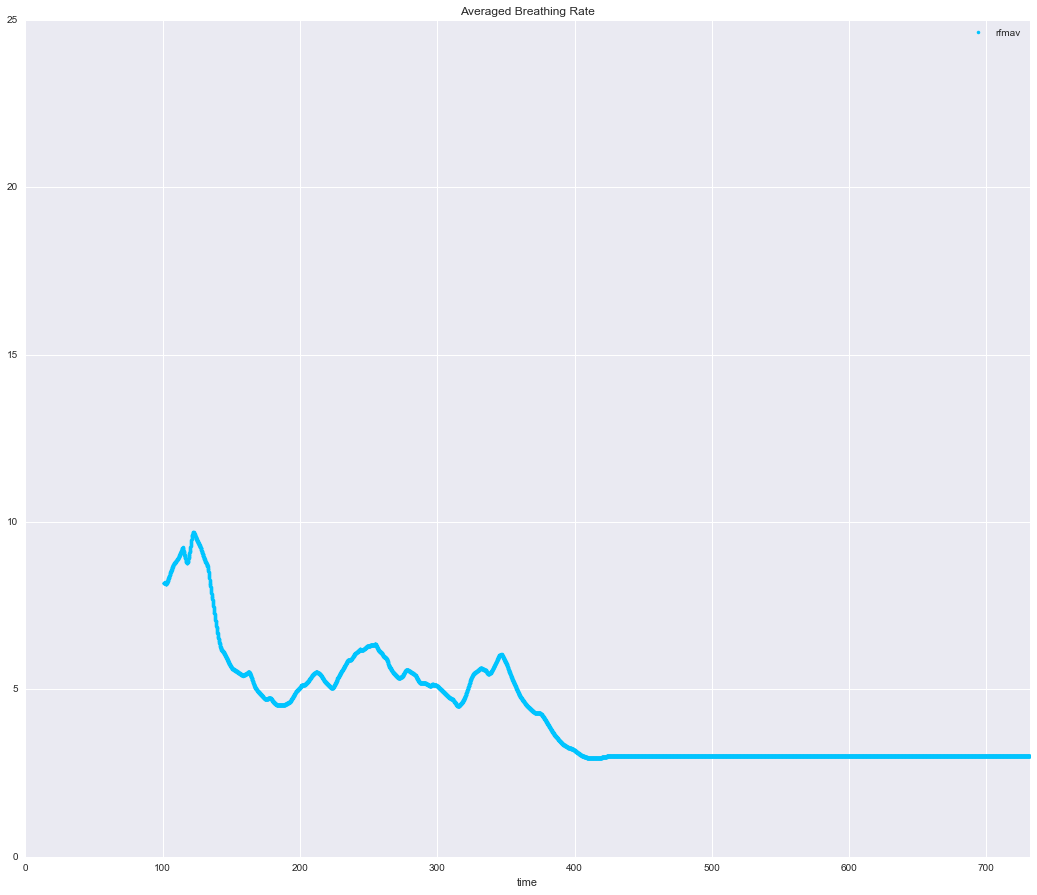

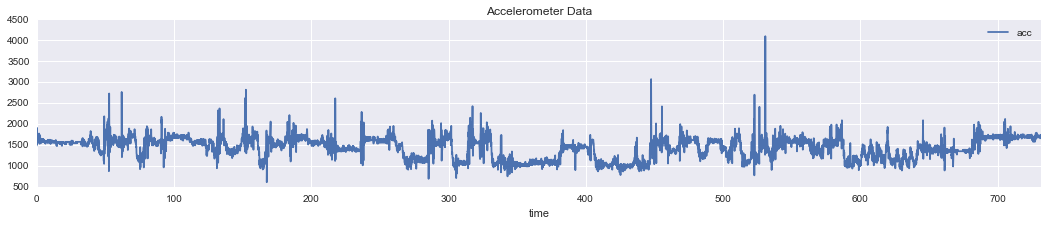

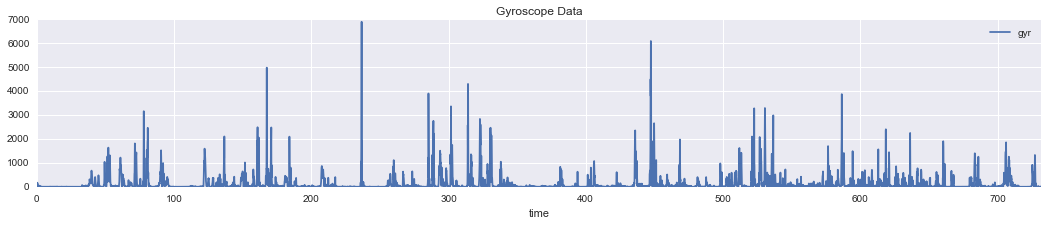

In [19]:
# this is just for plotting data 
g = f
g['cesm'] = f['cesm'] - 500
g['cmav'] = f['cmav'] - 500
g['del'] = f['del'] + 1900
g['b1'] = 1900
g['ph1'] = 100*f['ph1'] + 2800
g['b2'] = 1600
g['ph2'] = 100*f['ph2'] + 2200
#g.plot(x = 'time',y = ['chest','belly','cesm','cmav','del','b1','ph1','b2'],figsize = (18,15),title = 'Chest Data Processing')
g.plot(style=['-'],x = 'time',y = ['del'],figsize = (18,15), ylim = (1500,3000), title = 'Chest Data Processing')
#g.plot(x = 'time',y = ['chest','belly','ph1','ph2'],figsize = (18,15),title = 'Breathing Raw Data')
#d.plot(x = 'time',y = ['rlast','flast'], figsize = (18,3), title = 'Length of last detected breath, based on successive rise (r) and fall (f) times.')
d.plot(style=['.'], x = 'time',y = ['rfmav'], color = '#00C4FF', ylim = (0,25), figsize = (18,15), title = 'Averaged Breathing Rate')
d.plot(x = 'time',y = 'acc',figsize = (18,3),title = 'Accelerometer Data')
d.plot(x = 'time',y = 'gyr',figsize = (18,3),title = 'Gyroscope Data')

Note that all moving averages are calculated using only data available at the time, which causes the corresponding curves to lag behind (compare moving averages of breath times to real-time breath times above). 

In [20]:
print(d[::1000]) # every thousandth line of the processed dataset

      index  chest  belly  ax  ay  az  gx  gy  gz   time  ...       fmav  \
0         0   3188   3028  10  30  22   4   7   4    0.0  ...        NaN   
1000   1000   3173   2979  12  25  32   0   0   0  100.0  ...        NaN   
2000   2000   3201   2861  15  32  17  -3   0   1  200.0  ...   4.969904   
3000   3000   3162   2877  11  31  25   4  -2   1  300.0  ...   4.733728   
4000   4000   3214   2990  -6 -16  34  -1  -1   0  400.0  ...   2.971866   
5000   5000   3225   2899  -8 -17  33   2  -2   1  500.0  ...   2.620087   
6000   6000   3210   2853 -16 -24  16  -4  -3   1  600.0  ...   2.620087   
7000   7000   3256   3010  12  27  29  -1   2   3  700.0  ...   2.620087   

         rfmav     brmav     bfmav    brfmav   cbrfmav   acc  gyr    b1    b2  
0          NaN       NaN       NaN       NaN       NaN  1484   81  1900  1600  
1000       NaN  4.930089  4.173139  4.551614       NaN  1793    0  1900  1600  
2000  5.061313  8.184608  9.264263  8.724436  5.427625  1538   10  1900  16

In [21]:
d.head(6000)

,index,chest,belly,ax,ay,az,gx,gy,gz,time,...,fmav,rfmav,brmav,bfmav,brfmav,cbrfmav,acc,gyr,b1,b2
0,0,3188,3028,10,30,22,4,7,4,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,1484,81,1900,1600
1,1,3190,3040,7,31,25,-3,1,-1,0.1,...,NaN,NaN,NaN,NaN,NaN,NaN,1635,11,1900,1600
2,2,3202,3050,10,31,22,7,-11,-2,0.2,...,NaN,NaN,NaN,NaN,NaN,NaN,1545,174,1900,1600
3,3,3206,3052,14,35,22,1,-4,-1,0.3,...,NaN,NaN,NaN,NaN,NaN,NaN,1905,18,1900,1600
4,4,3210,3052,9,31,22,-3,-2,0,0.4,...,NaN,NaN,NaN,NaN,NaN,NaN,1526,13,1900,1600
5,5,3208,3056,11,30,24,-11,-6,-3,0.5,...,NaN,NaN,NaN,NaN,NaN,NaN,1597,166,1900,1600
6,6,3198,3047,14,29,26,-10,-5,-3,0.6,...,NaN,NaN,NaN,NaN,NaN,NaN,1713,134,1900,1600
7,7,3202,3053,12,29,25,-8,-2,-1,0.7,...,NaN,NaN,NaN,NaN,NaN,NaN,1610,69,1900,1600
8,8,3190,3055,13,27,27,-2,-3,0,0.8,...,NaN,NaN,NaN,NaN,NaN,NaN,1627,13,1900,1600
9,9,3202,3061,13,29,26,3,2,3,0.9,...,NaN,NaN,NaN,NaN,NaN,NaN,1686,22,1900,1600
